In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def dbscan(data, columns, eps, min_samples):

    def euclidean_distance(p1, p2):
        return math.sqrt(sum((p1[i] - p2[i]) ** 2 for i in range(len(columns))))
    
    def get_neighbors(point, data):
        neighbors = []
        for other_point in data:
            if euclidean_distance(point, other_point) <= eps:
                neighbors.append(tuple(other_point))
        return neighbors
    
    # Identify core points
    core_points = [tuple(point) for point in data if len(get_neighbors(point, data)) >= min_samples]
    
    # Expand clusters from core points
    visited = set()
    clusters = []
    
    for core_point in core_points:
        if core_point in visited:
            continue  # Skip if we've already processed this point
        
        # Start a new cluster
        cluster = []
        points_to_visit = [core_point]
        
        while points_to_visit:
            point = points_to_visit.pop()
            if point in visited:
                continue  # Skip points that have already been visited
            
            visited.add(point)
            cluster.append(point)
            
            # Get neighbors and expand if they are also core points
            neighbors = get_neighbors(point, data)
            if len(neighbors) >= min_samples:
                # Only expand from core points
                for neighbor in neighbors:
                    if neighbor not in visited:
                        points_to_visit.append(neighbor)
        
        clusters.append(cluster)  # Add the formed cluster to the list of clusters
    
    # Identify and label noise points
    noise = [tuple(point) for point in data if tuple(point) not in visited]
    
    return clusters, noise

In [2]:
# Load the data
data = pd.read_csv('weatherIncluded3.csv')

# Define the columns to use for clustering (e.g., ['x', 'y'] for 2D coordinates)
columns = ['Air Temperature', 'Relative Humidity', 'Air Pressure', 'Track Temperature', 'Wind Speed']

# Convert to list of lists for DBSCAN
data_points = data[columns].values.tolist()

# Define DBSCAN parameters
eps = 20
min_samples = 5

# Run DBSCAN
clusters, noise = dbscan(data_points, columns, eps, min_samples)

# Print results
print("Clusters:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {cluster}")

print("\nNoise points:")
print(noise)

Clusters:
Cluster 1: [(24.077477477477483, 30.91531531531532, 997.0036036036036, 36.32432432432432, 3.691891891891891), (33.1015037593985, 32.285714285714285, 993.2285714285714, 49.31127819548872, 1.518796992481203), (28.82387096774194, 46.92258064516129, 981.6767741935486, 44.91612903225806, 1.2496774193548386), (21.32846715328467, 49.583941605839414, 978.0963503649637, 42.26715328467153, 1.6832116788321163), (29.96011904761904, 41.910714285714285, 993.7309523809524, 40.62857142857143, 3.314285714285714), (25.113986013986015, 48.42657342657343, 1006.634265734266, 42.023776223776224, 2.141258741258741), (26.70592105263158, 38.01973684210526, 1017.6401315789471, 44.34934210526316, 1.5513157894736842), (21.691160220994476, 43.430939226519335, 1012.3723756906076, 37.50110497237569, 2.2408839779005527), (28.521999999999995, 59.00666666666667, 1016.4626666666668, 44.664, 3.080666666666666), (30.786250000000003, 74.65, 1008.024375, 36.445625, 0.955), (24.132467532467533, 63.44155844155844, 1

/var/folders/nh/g3mv0wms0ss2dw3kgtlk_p1h0000gn/T/ipykernel_11716/1696447837.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(clusters) + 1)


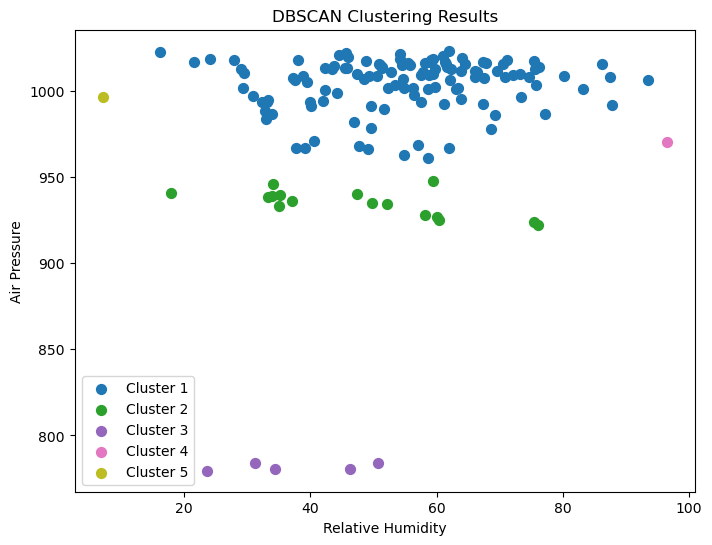

In [3]:
def plot_clusters(clusters, noise):
    # Assign a unique color to each cluster
    colors = plt.cm.get_cmap('tab10', len(clusters) + 1)

    plt.figure(figsize=(8, 6))

    # Plot each cluster with a unique color
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        plt.scatter(cluster_points[:, 1], cluster_points[:, 2], s=50, color=colors(i), label=f'Cluster {i+1}')
    
    # Plot noise points in gray
    if noise:
        noise_points = np.array(noise)
        plt.scatter(noise_points[:, 0], noise_points[:, 1], s=50, color='lightgrey', label='Noise')
    
    plt.title("DBSCAN Clustering Results")
    plt.xlabel("Relative Humidity")
    plt.ylabel("Air Pressure")
    plt.legend()
    plt.show()

# Call the plot function with the clusters and noise from dbscan output
plot_clusters(clusters, noise)

In [4]:
import numpy as np

def silhouette_score(clusters):
    
    def euclidean_distance(point1, point2):
        return math.sqrt(sum((point1[i] - point2[i]) ** 2 for i in range(len(columns))))
    
    # Calculate the centroid of a cluster
    def calculate_centroid(cluster):
        return np.mean(cluster, axis=0)
    
    # List to store silhouette scores for each point
    silhouette_scores = []
    
    # Calculate centroids of all clusters
    cluster_centroids = [calculate_centroid(cluster) for cluster in clusters]
    for c in cluster_centroids:
        print(type(c))
        print(c)
    
    # Calculate silhouette score for each cluster and each point
    for cluster_idx, cluster in enumerate(clusters):
        for point in cluster:
            # Step 1: Intra-cluster distance (a)
            intra_distances = [
                euclidean_distance(point, other_point) for other_point in cluster if other_point != point
            ]
            a = np.mean(intra_distances) if intra_distances else 0  # avoid divide by zero if single point cluster

            # Step 2: Inter-cluster distance (b) - distance to nearest other cluster's centroid
            inter_distances = [
                euclidean_distance(point, centroid) for idx, centroid in enumerate(cluster_centroids) if idx != cluster_idx
            ]
            b = min(inter_distances) if inter_distances else 0  # avoid if no other clusters
            
            # Step 3: Silhouette score for this point
            if max(a, b) > 0:
                silhouette_score_point = (b - a) / max(a, b)
            else:
                silhouette_score_point = 0  # Handle cases with zero distances
            silhouette_scores.append(silhouette_score_point)
    
    # Return the average silhouette score
    overall_silhouette_score = np.mean(silhouette_scores)
    return overall_silhouette_score

# Example usage:
# Assuming clusters are already computed using dbscan function
clusters, noise = dbscan(data_points, columns, eps, min_samples)
sil_score = silhouette_score(clusters)
print(f"Silhouette Score: {sil_score}")


<class 'numpy.ndarray'>
[  23.69486681   54.75797045 1003.84918854   34.95290131    1.70698314]
<class 'numpy.ndarray'>
[ 22.86310486  47.80835124 934.64514177  40.53688777   1.44381415]
<class 'numpy.ndarray'>
[ 22.87860434  37.2406661  781.76861164  42.20229121   1.21587371]
<class 'numpy.ndarray'>
[1.30124138e+01 9.64358621e+01 9.70221724e+02 1.52586207e+01
 5.11379310e-01]
<class 'numpy.ndarray'>
[ 36.56585366   7.1097561  996.01585366  48.95731707   3.48841463]
Silhouette Score: 0.36333698959419797


In [5]:
def euclidean_distance(point1, point2):
        return math.sqrt(sum((point1[i] - point2[i]) ** 2 for i in range(len(columns))))

def calculate_separation_point(point, centroids, columns, cluster, clusterPoints):
  # figure out closest cluster 
  centroidDistances = []
  centroidNum = 0
  for i in range(len(centroids) - 1):
      distToCentroid = euclidean_distance(centroids[cluster-1], centroids[i+1], columns)
      centroidDistances.append(distToCentroid)
  closestCentroid = min(centroidDistances)
  
  for j in range(0, len(centroidDistances)):
    if centroidDistances[i] == closestCentroid:
      centroidNum = i
  
  averageDistances = []
  for k in range(len(clusterPoints[centroidNum])):
    averageDistances.append(euclidean_distance(point, clusterPoints[centroidNum][k], columns))
  print(averageDistances)